<a href="https://colab.research.google.com/github/427paul/Machine_Learning/blob/main/DL_2_2_%ED%9A%8C%EA%B7%80_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **종합실습1 : Carseat 판매량 예측**


## **1.환경준비**

### (1) 라이브러리 Import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [18]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [19]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [20]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [21]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [22]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [23]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(path)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


|	변수명	|	설명	|	구분	|
|	----	|	----	|	----	|
|	Sales 	|	 각 지역 판매량(단위 : 1000개)	|	Target	|
|	CompPrice 	|	지역별 경쟁사 판매가격(달러)	|	feature	|
|	Income 	|	가구당 평균 소득액(1000달러)	|	feature	|
|	Advertising 	|	 각 지역, 회사의 광고 예산(1000달러)	|	feature	|
|	Population 	|	 지역 인구수(단위 : 1000명)	|	feature	|
|	Price 	|	 자사 지역별 판매가격(달러)	|	feature	|
|	ShelveLoc 	|	 진열상태(범주 : Bad, Medium, Good)	|	feature	|
|	Age 	|	 지역 인구의 평균 연령	|	feature	|
|	Education 	|	 교육수준(범주 : 10~18)	|	feature	|
|	Urban 	|	 매장이 도심에 있는지 여부(범주 : Yes, No)	|	feature	|
|	US 	|	 매장이 미국에 있는지 여부(범주 : Yes, No)	|	feature	|


## **2.데이터 준비**

### (1) 데이터 준비
* x, y 나누기

In [24]:
target = 'Sales'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 가변수화
* 범주형 변수에 대해서 가변수화를 수행합니다.

In [25]:
cat_cols = ['ShelveLoc', 'Education', 'Urban', 'US']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

### (3) 데이터분할

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

### (4) Scaling

In [27]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (5) 텐서로 변환, 데이터로더 준비

In [28]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [29]:
for x, y in train_loader:
  print(f"Shape of x [rows, columns]: {x.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of x [rows, columns]: torch.Size([32, 18])
Shape of y: torch.Size([32, 1]) torch.float32


## **3.모델링1**

### (1) 모델 선언

In [30]:
x.shape[1]

18

In [31]:
n_feature = x.shape[1]

model1 = nn.Sequential(
    nn.Linear(n_feature, 1)
).to(device)

print(model1)

Sequential(
  (0): Linear(in_features=18, out_features=1, bias=True)
)


In [33]:
loss_fn = nn.MSELoss()
optimizer = Adam(model1.parameters(), lr=0.1)

### (2) 학습

In [34]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
  tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
  val_loss, _ = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)

  tr_loss_list.append(tr_loss)
  val_loss_list.append(val_loss)

  print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 28.884521, val loss : 9.292356
Epoch 2, train loss : 8.849787, val loss : 11.969509
Epoch 3, train loss : 9.197556, val loss : 8.470964
Epoch 4, train loss : 6.523914, val loss : 8.414479
Epoch 5, train loss : 6.377883, val loss : 7.930524
Epoch 6, train loss : 5.766770, val loss : 7.731679
Epoch 7, train loss : 5.517529, val loss : 7.510087
Epoch 8, train loss : 5.292448, val loss : 7.268776
Epoch 9, train loss : 5.095194, val loss : 7.066891
Epoch 10, train loss : 4.911165, val loss : 6.831899
Epoch 11, train loss : 4.789459, val loss : 6.607816
Epoch 12, train loss : 4.671949, val loss : 6.448575
Epoch 13, train loss : 4.527834, val loss : 6.208496
Epoch 14, train loss : 4.393114, val loss : 6.074895
Epoch 15, train loss : 4.371091, val loss : 5.937942
Epoch 16, train loss : 4.147728, val loss : 5.721034
Epoch 17, train loss : 4.078756, val loss : 5.581261
Epoch 18, train loss : 3.988573, val loss : 5.386580
Epoch 19, train loss : 3.897451, val loss : 5.278567


In [35]:
for name, param in model1.named_parameters():
  if param.requires_grad:
    print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[ 5.4772,  2.0642,  2.7691,  0.5903, -7.2951, -1.7983,  4.9668,  2.0856,
          0.6471,  0.5582,  0.2327,  0.3058,  1.2139,  0.4897,  0.5489,  0.4802,
          0.3525,  0.1888]])
Parameter: 0.bias, Value: tensor([5.2054])


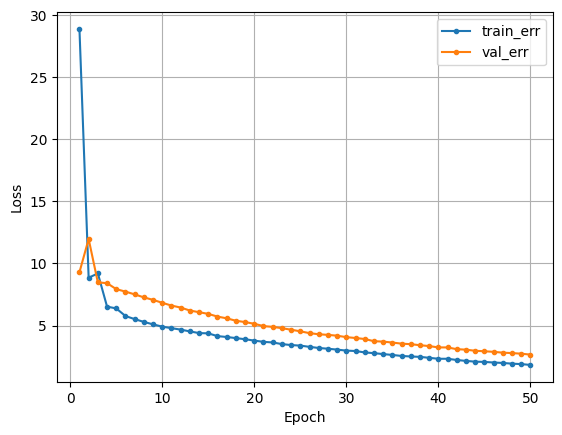

In [36]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 모델 평가

In [37]:
loss, pred = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
print(f"MSE: {loss}")

MSE: 2.6598317623138428


In [39]:
mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MAE: 1.2787061929702759
MAPE: 157403790180352.0


## **4.모델링2**

### (1) 모델 선언

### (2) 학습

### (3) 모델 평가